<a href="https://colab.research.google.com/github/RobertHuangLehigh/DSCI441_Project/blob/main/4_15_of_DSCI441_Project_Huang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install some packages
#!pip install h5py
#!pip install typing-extensions
#!pip install wheel
!pip install gdown
!pip install tensorflow_text
!pip install wordcloud
!pip install tensorflow-gpu

In [5]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.autograph.set_verbosity(0)
#import packages and set up default setting
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
#give permission for Colab to read dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df=pd.read_csv("/content/drive/MyDrive/dataset/Reviews.csv") #read the dataset
df.head()#show the first 5 rows of the dataset

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [8]:
#show the information of the sataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
# count the scores for reviews by stars
df.Score.value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

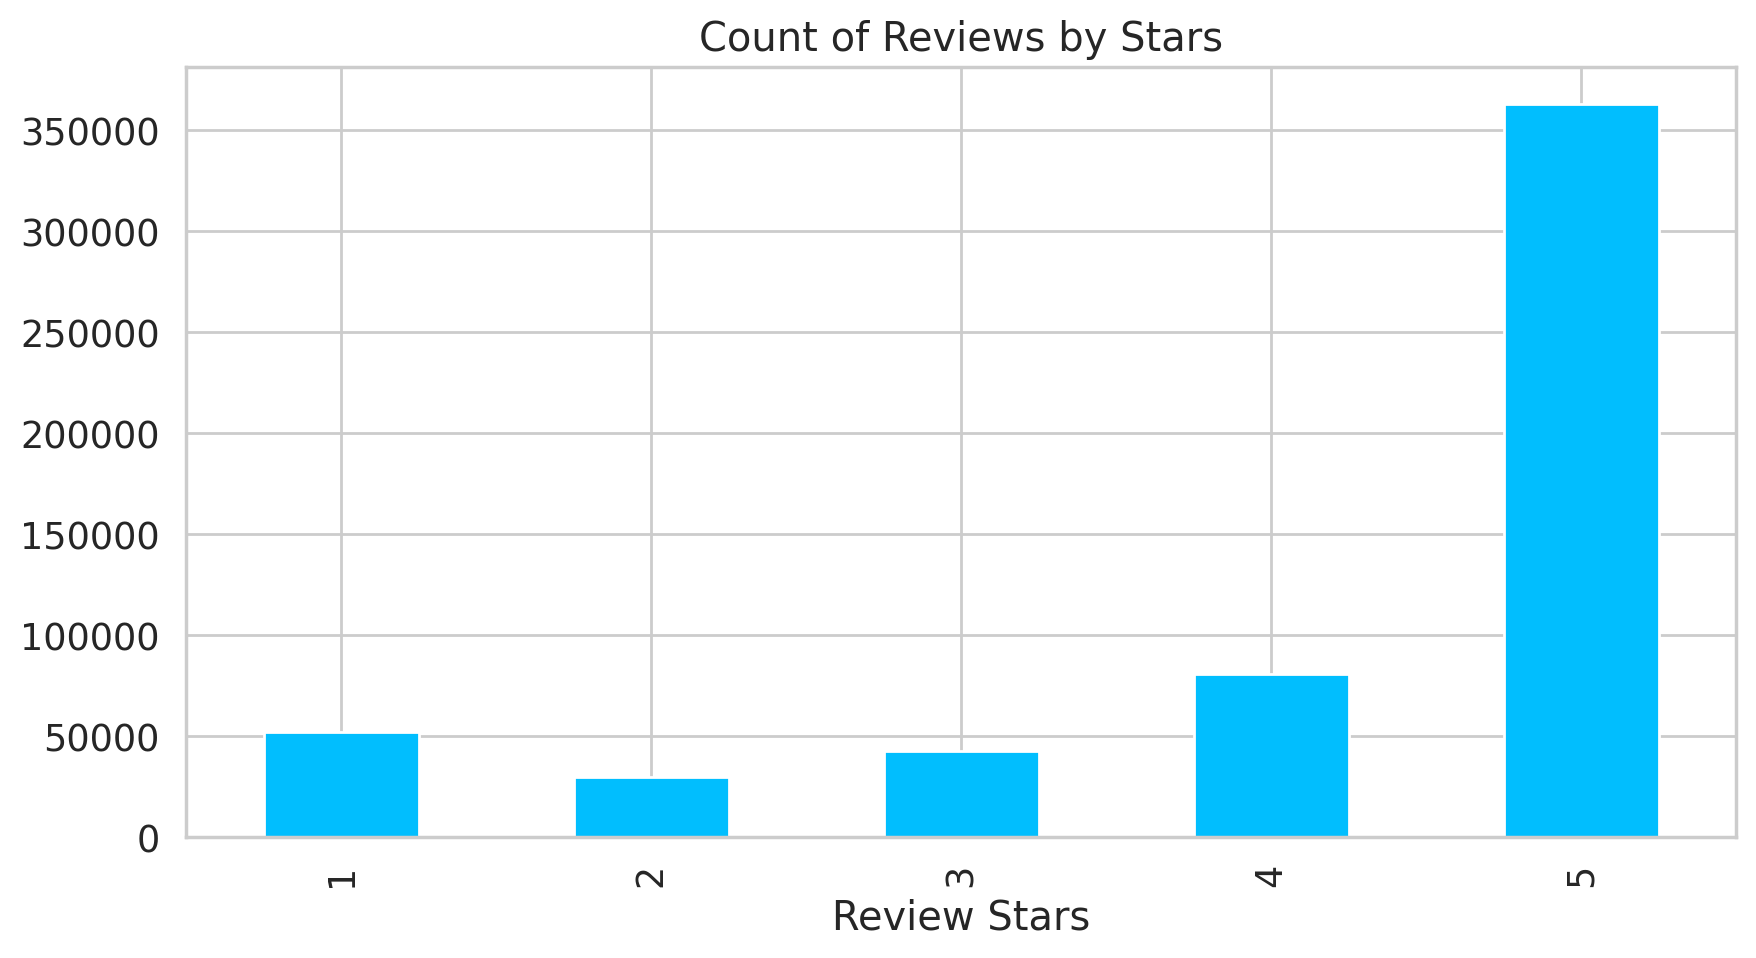

In [10]:
#plot the bar chart to show the distribution of reviews by stars
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

<Axes: >

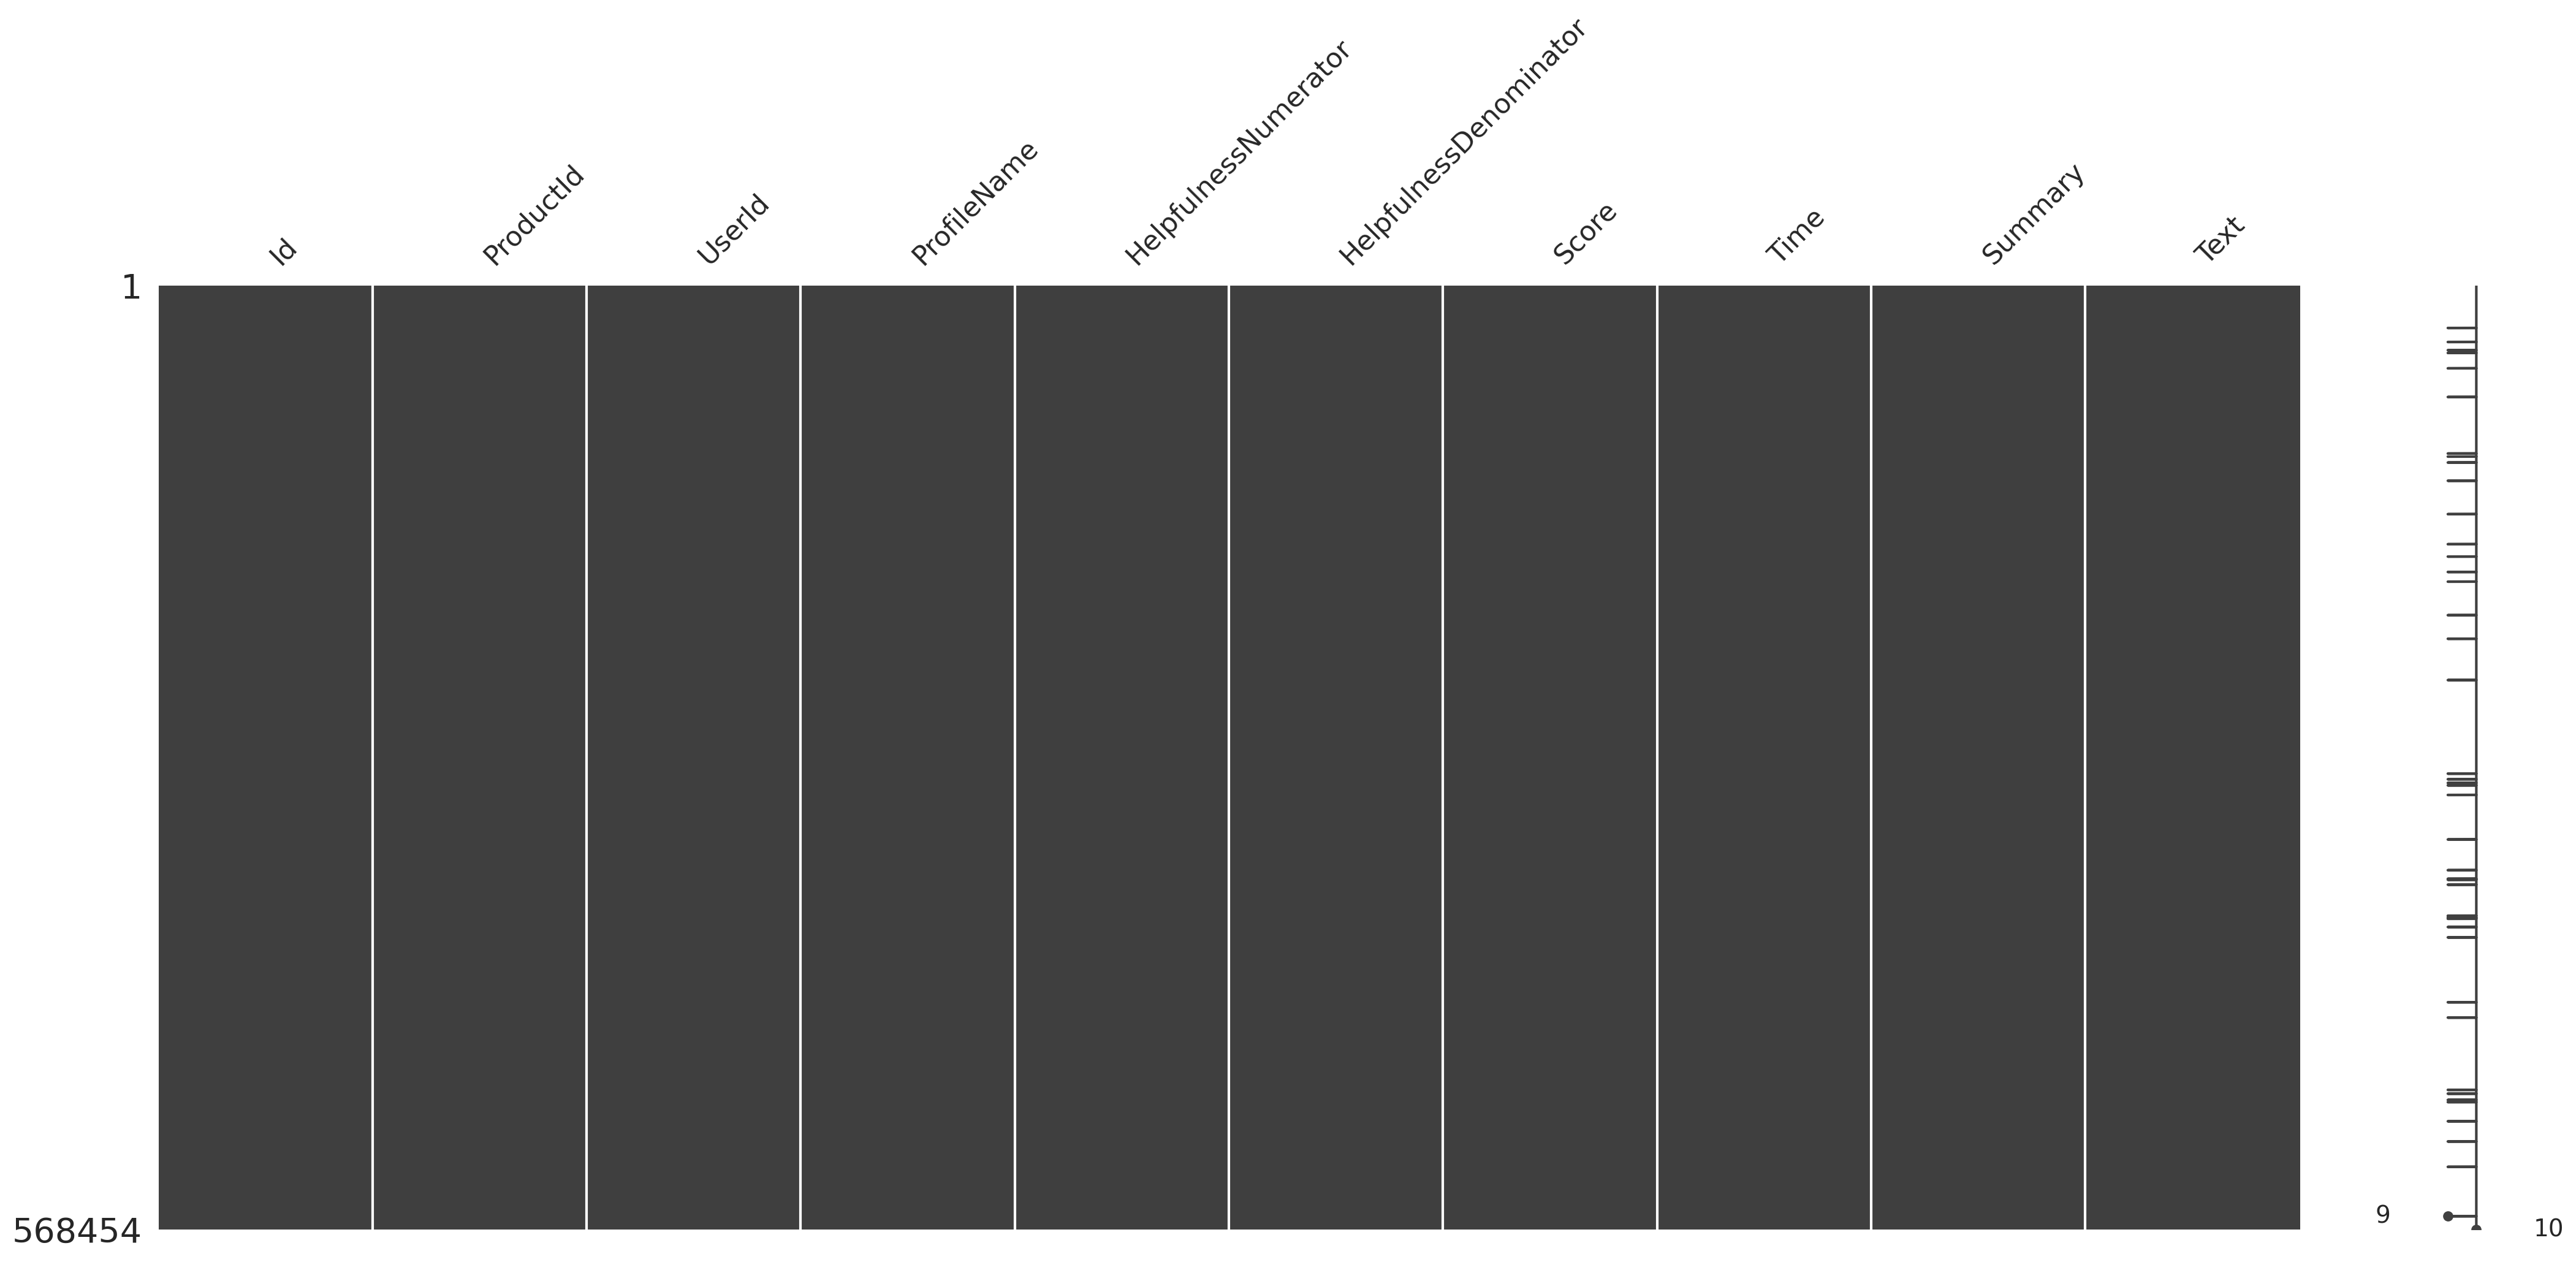

In [11]:
#check if there is any missing value, the result shows that there is no missing value
import missingno as msno
msno.matrix(df)

In [12]:
#data cleaning: only remain score and review for building the model and further analysis
del df['Id']
del df['ProductId']
del df['UserId']
del df['ProfileName']
del df['HelpfulnessNumerator']
del df['HelpfulnessDenominator']
del df['Time']
df['review'] = df['Summary']+df['Text']
del df['Summary']
del df['Text']
df.review.fillna("",inplace = True)
df.head()

Score                                             review
0      5  Good Quality Dog FoodI have bought several of ...
1      1  Not as AdvertisedProduct arrived labeled as Ju...
2      4  "Delight" says it allThis is a confection that...
3      2  Cough MedicineIf you are looking for the secre...
4      5  Great taffyGreat taffy at a great price.  Ther...

In [13]:
#reduce the size from 568454 to 5000 since it takes hours to run the model with original dataset
df = df.head(5000)

In [14]:
#define and categorize review socre to "positive", "neutral", and "negative"
df["review_type"] = df["Score"].apply(lambda x: "neutral" if x==3 else "negative" if x < 4  else "positive")

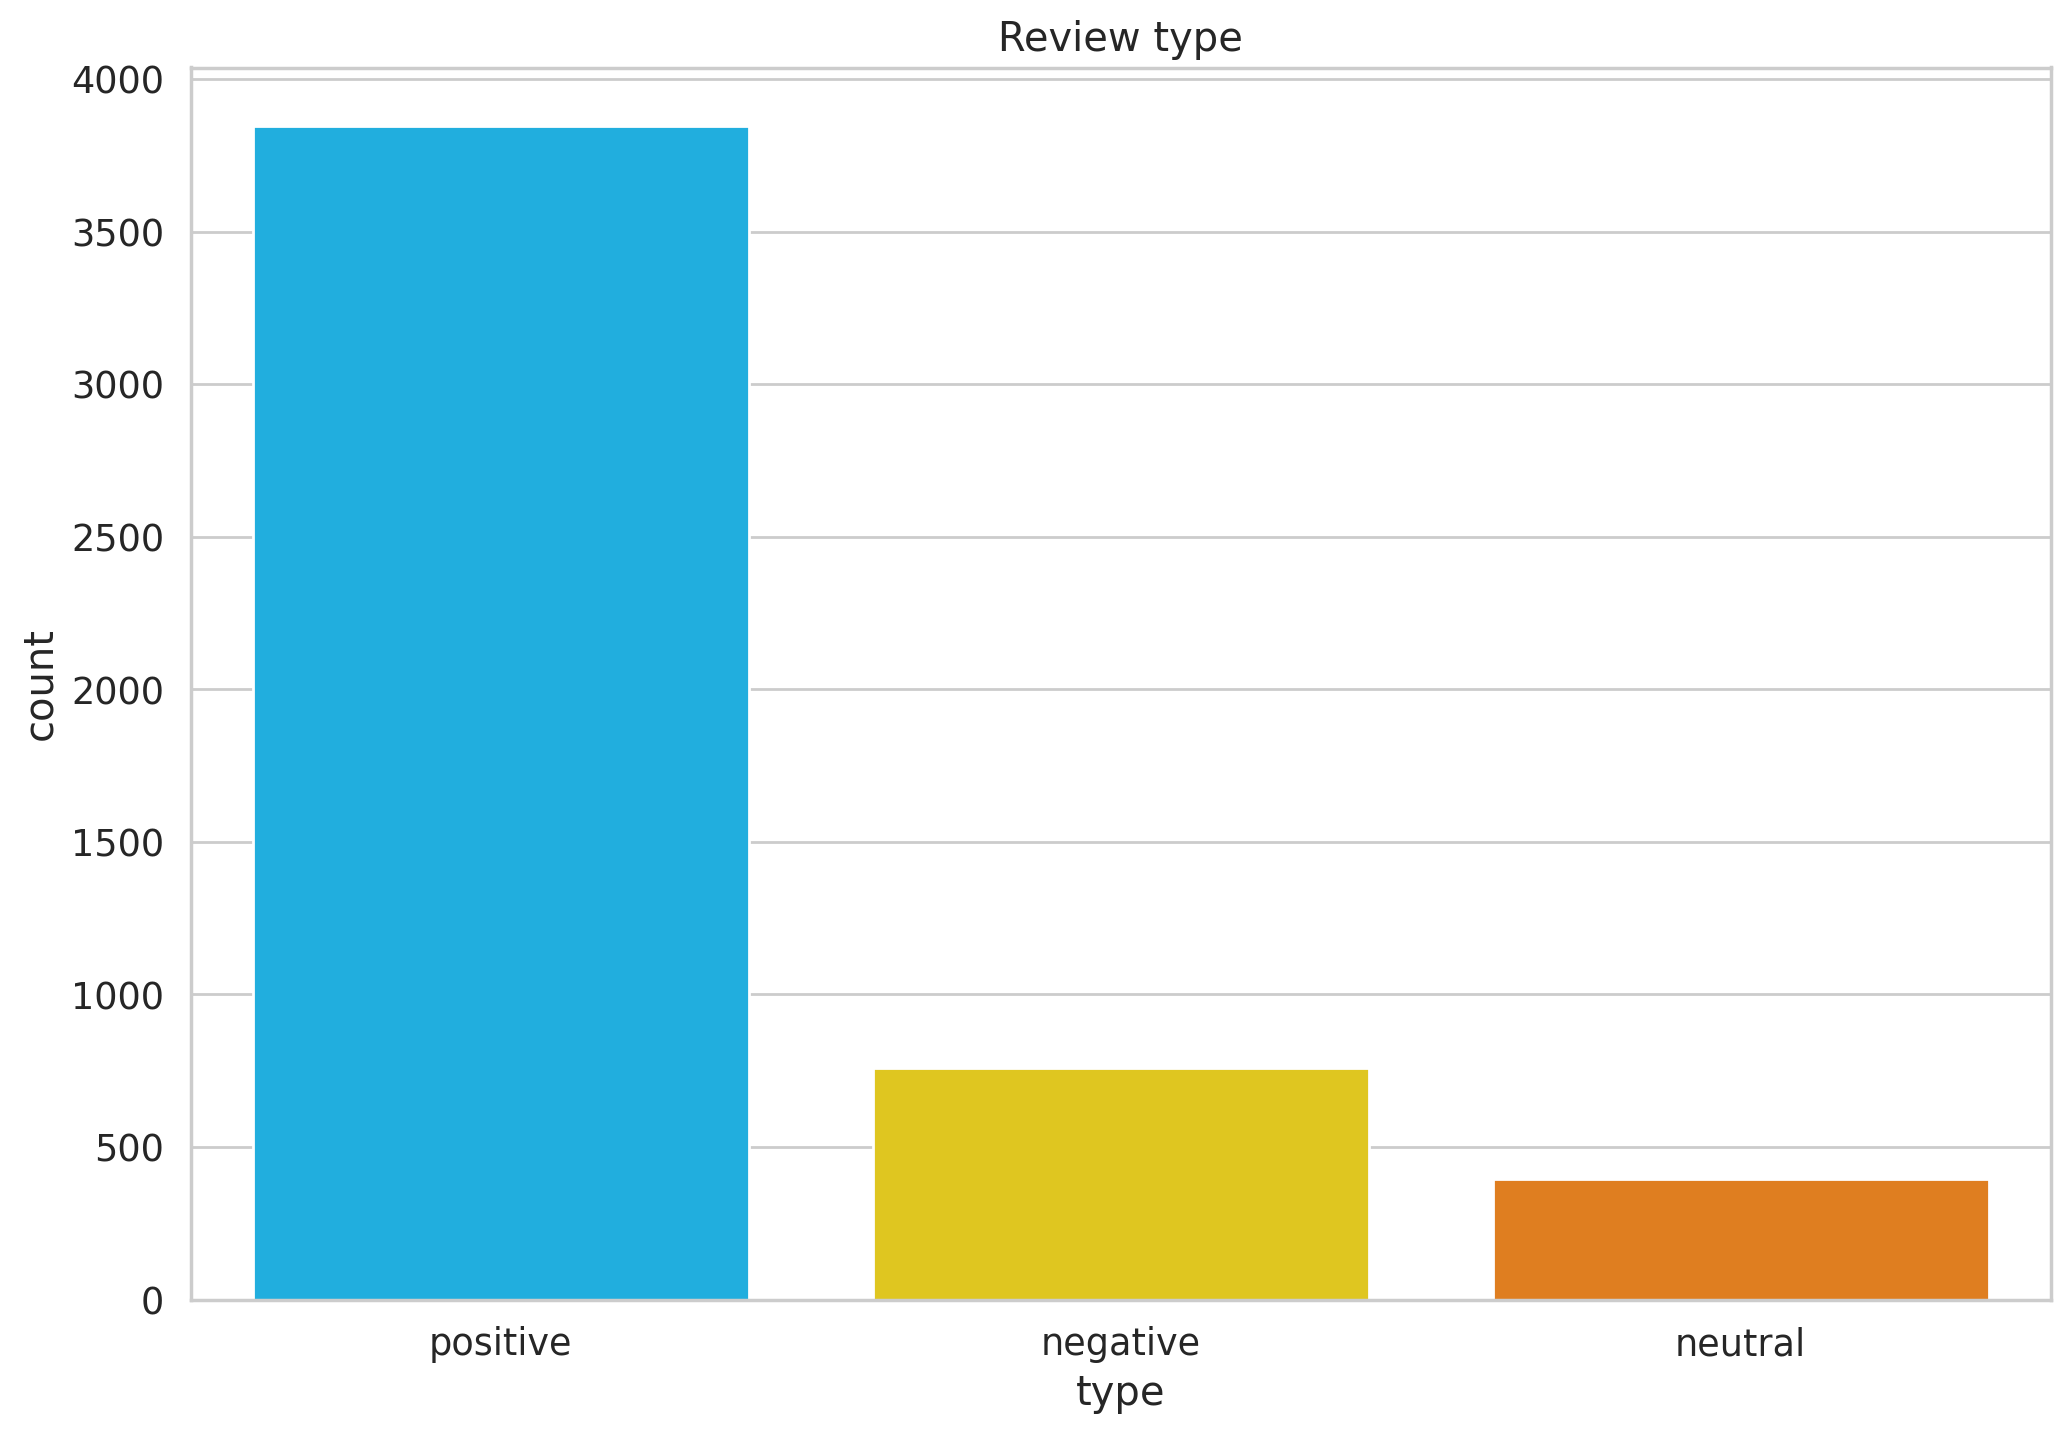

In [15]:
#show the distribution of 3 review types
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)
plt.xlabel("type")
plt.title("Review type");

In [16]:
#count the amount of positive and negative review
positive_reviews = df[df.review_type == "positive"]
negative_reviews = df[df.review_type == "negative"]
print(positive_reviews.shape, negative_reviews.shape)

(3846, 3) (759, 3)


In [17]:
#create word cloud to show common words in positive and negative reviews
positive_reviews_text = " ".join(positive_reviews.review.to_numpy().tolist())
negative_reviews_text = " ".join(negative_reviews.review.to_numpy().tolist())
positive_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(positive_reviews_text)
negative_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(negative_reviews_text)

In [18]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (20, 20))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

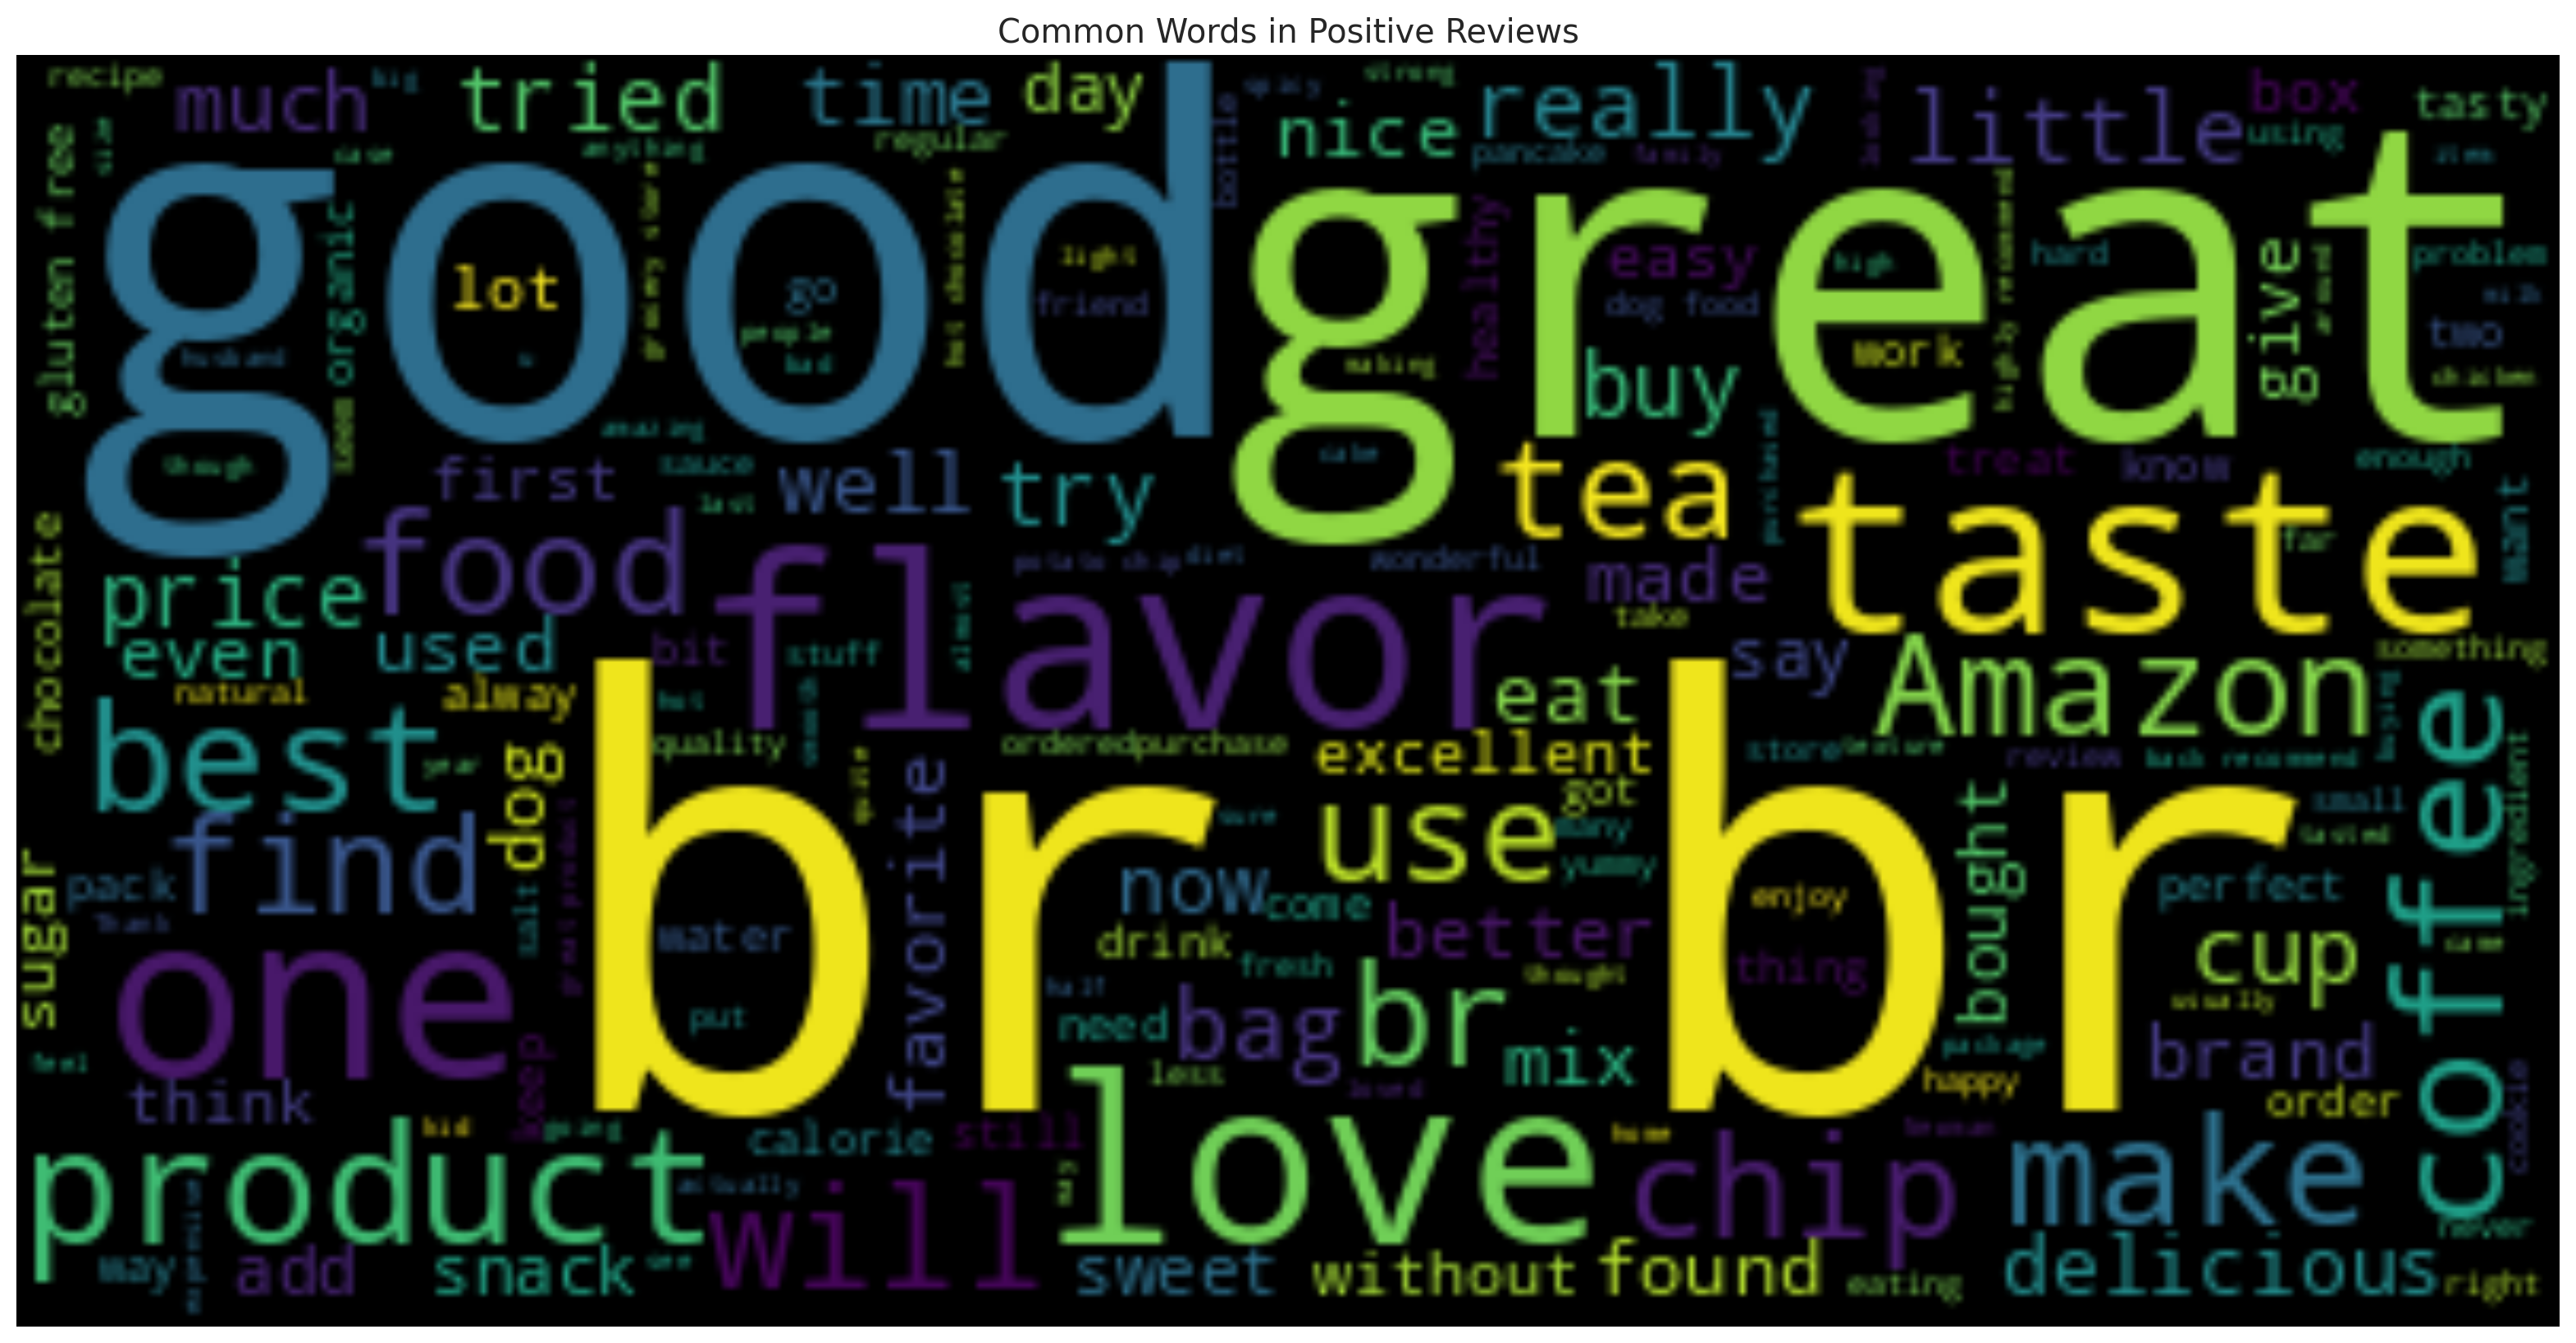

In [19]:
show_word_cloud(positive_reviews_cloud, "Common Words in Positive Reviews")

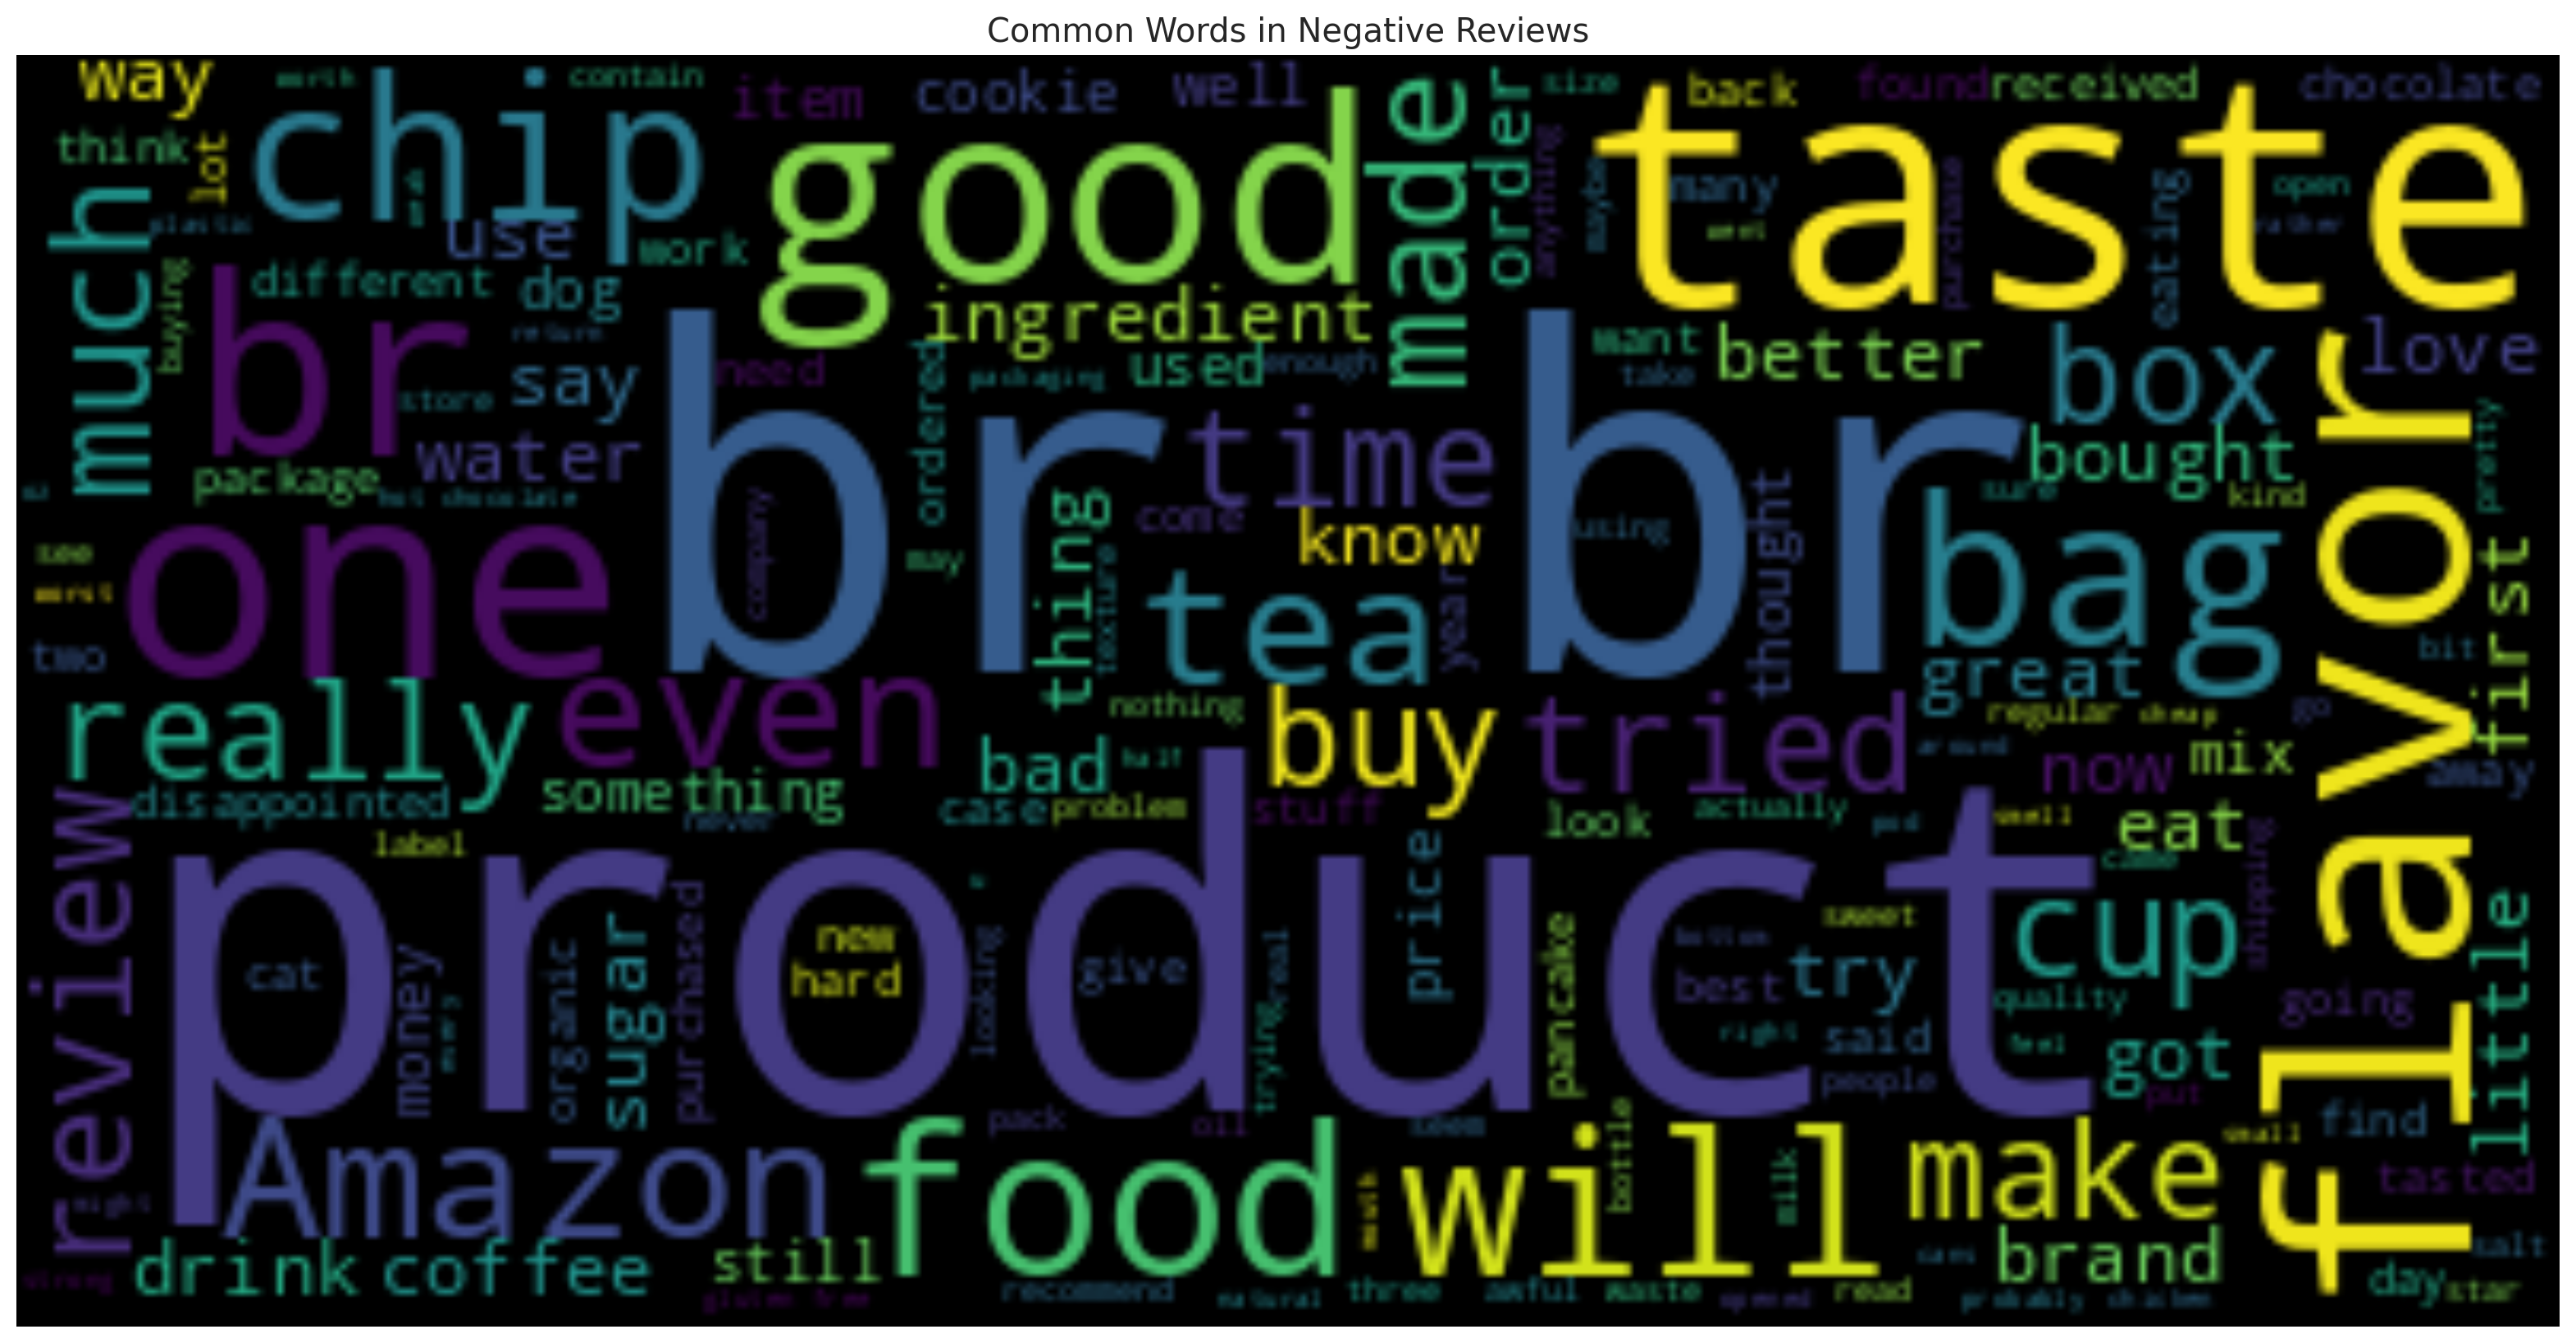

In [20]:
show_word_cloud(negative_reviews_cloud, "Common Words in Negative Reviews")

In [21]:
positive_df = positive_reviews.sample(n=len(negative_reviews), random_state=RANDOM_SEED)
negative_df = negative_reviews

In [22]:
review_df = positive_df.append(negative_df).reset_index(drop=True)
review_df.shape

(1518, 3)

In [23]:
#show the head of dataset after creating the review_type column for positive review
review_df.head()

Score                                             review review_type
0      5  PopchipsPopchips are phenomenal!  Unfortunatel...    positive
1      5  Subscribe and Save option is a good dealJust s...    positive
2      4  Does wonders for one's popularity in the kitch...    positive
3      5  Best  BrowniesYou CAN taste the flaxseed in th...    positive
4      5  i love this licorice!Quality and delicious lic...    positive

In [24]:
#show the tail fo dataset after creating the review_type column for negative review
review_df.tail()

Score                                             review review_type
1513      1  What Happened?!I purchase Banh Trang Spring Ro...    negative
1514      1  Amazon: please offer 3 ladies brand rice paper...    negative
1515      2  INDIGESTION OF MAJOR PROPORTIONSI have one cat...    negative
1516      2  The cavemen must have been wealthyI really wan...    negative
1517      1  These cookies need work; you can make your own...    negative

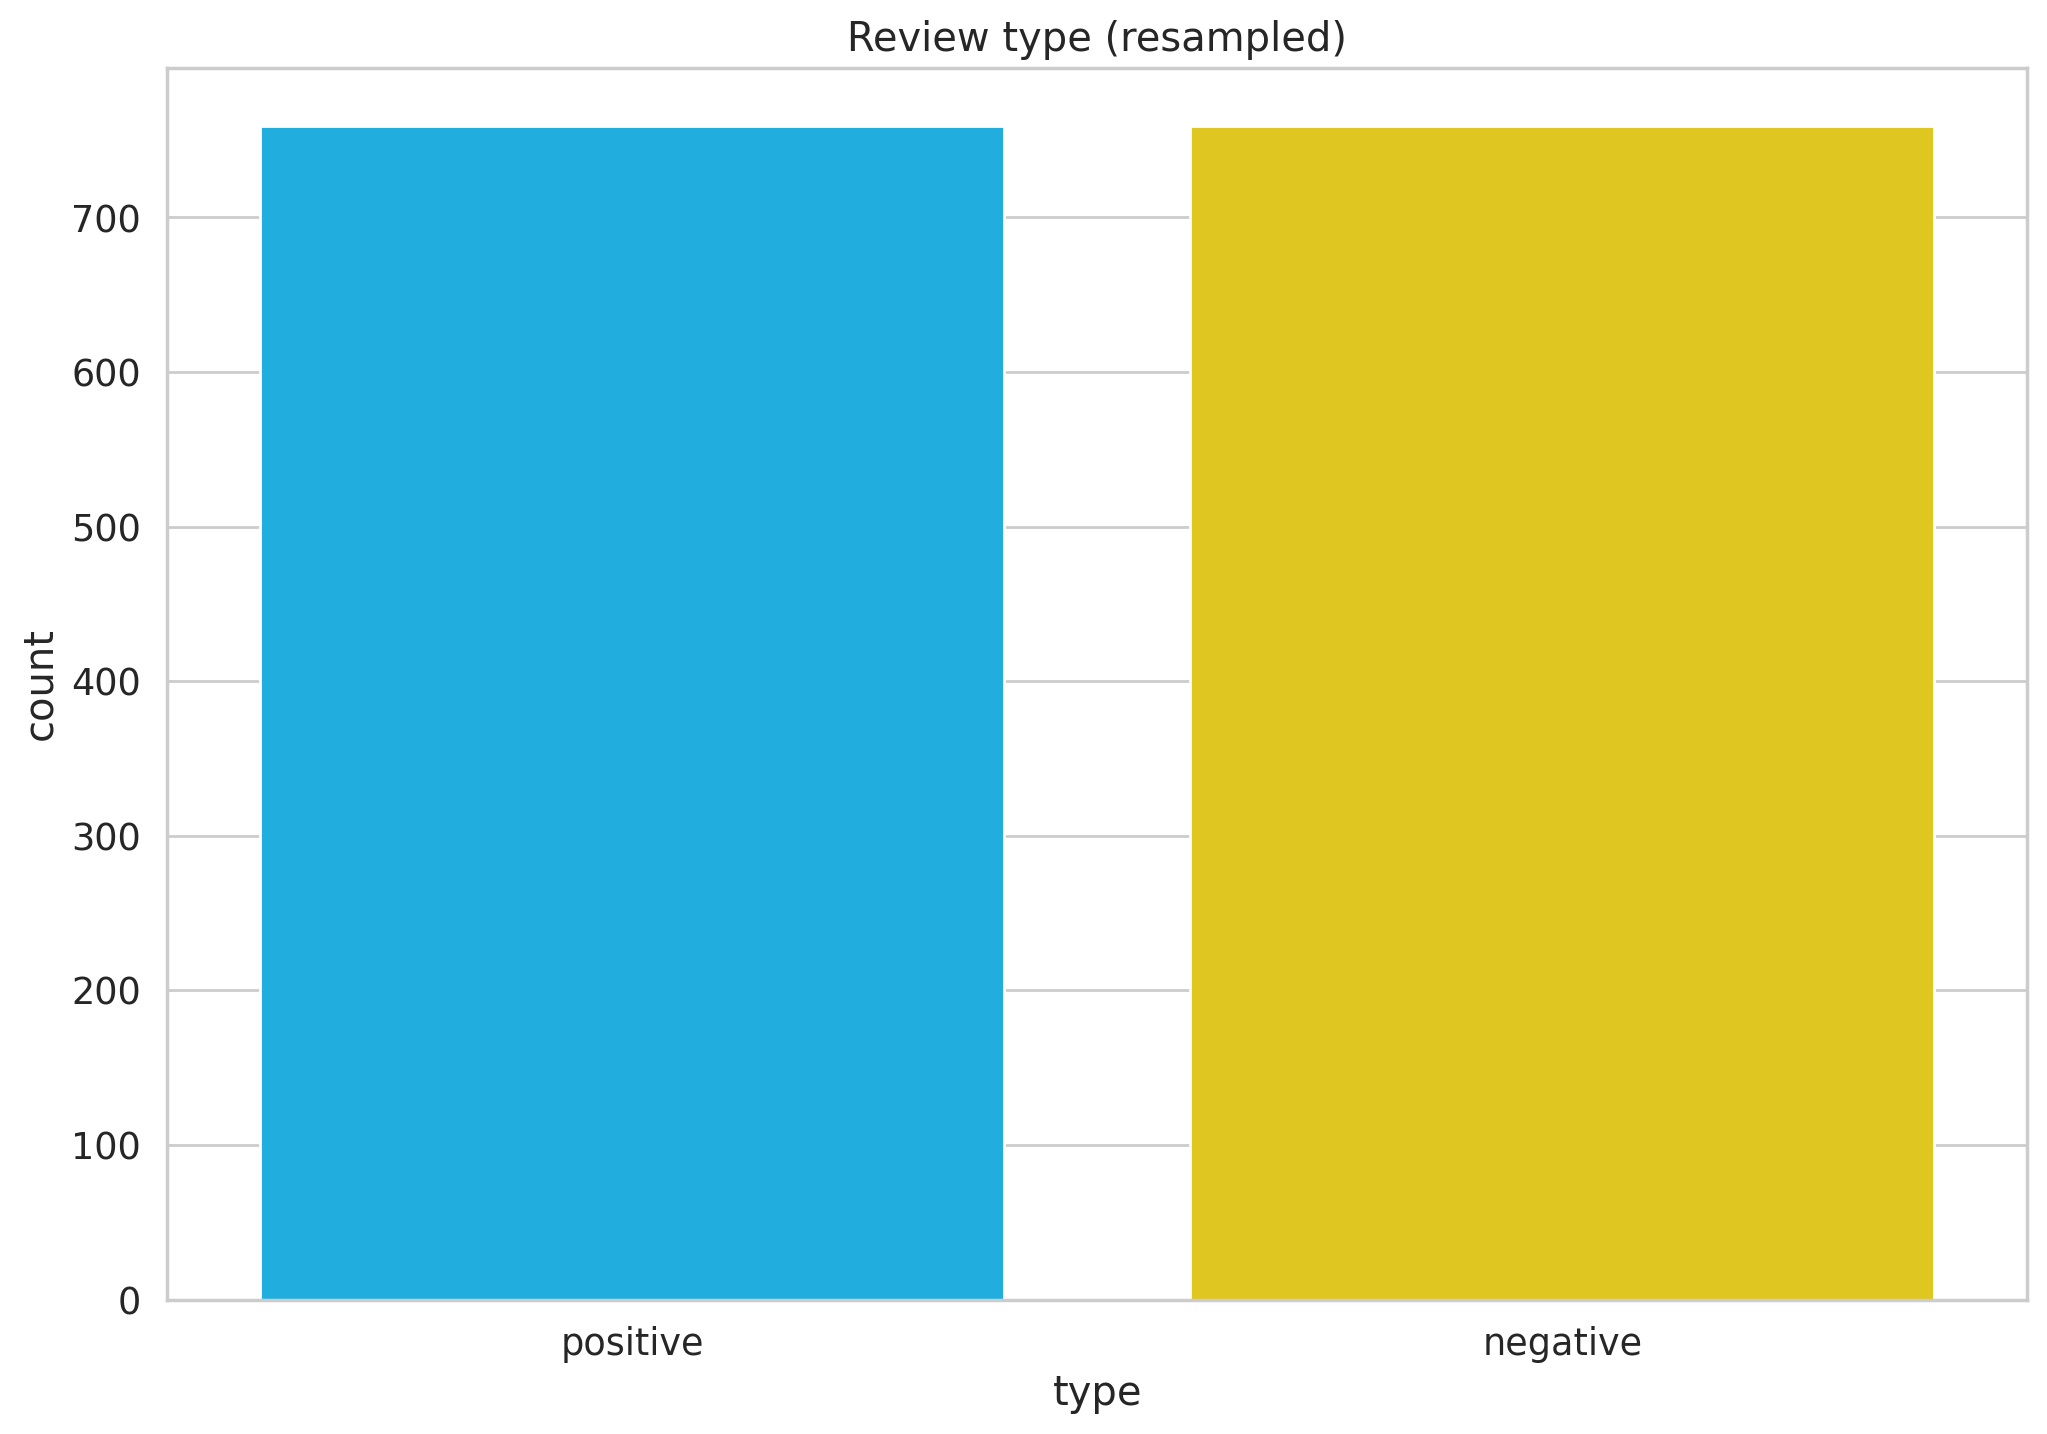

In [25]:
#resample the positive and nagative review type to the same since it's fair to do the analysis with it
#and show the plot after resampling
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

In [26]:
#load universal-sentence-encoder tool
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [27]:
#conduct OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [28]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1, 
    random_state=RANDOM_SEED
  )

In [29]:
#fit training dataset into Keras model
X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 1366/1366 [04:22<00:00,  5.20it/s]


In [30]:
#fit validation dataset into Keras model
X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 152/152 [00:28<00:00,  5.34it/s]


In [31]:
print(X_train.shape, X_test.shape)
print(X_train.shape, y_train.shape)

(1366, 512) (152, 512)
(1366, 512) (1366, 2)


In [32]:
#show the parameter use in Keras model
model = keras.Sequential()
model.add(keras.layers.Dense(units=256, input_shape=(X_train.shape[1], ), activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 164,482
Trainable params: 164,482
Non-trainable params: 0
_________________________________________________________________


In [33]:
#conduct validation process
history = model.fit(
    X_train, y_train, 
    epochs=15, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=True
)

Epoch 1/15
77/77 [==============================] - 3s 14ms/step - loss: 0.4829 - accuracy: 0.7917 - val_loss: 0.3021 - val_accuracy: 0.8978
Epoch 2/15
77/77 [==============================] - 1s 10ms/step - loss: 0.2507 - accuracy: 0.8967 - val_loss: 0.2828 - val_accuracy: 0.8978
Epoch 3/15
77/77 [==============================] - 1s 9ms/step - loss: 0.1861 - accuracy: 0.9365 - val_loss: 0.3158 - val_accuracy: 0.8759
Epoch 4/15
77/77 [==============================] - 1s 10ms/step - loss: 0.1486 - accuracy: 0.9455 - val_loss: 0.3331 - val_accuracy: 0.8978
Epoch 5/15
77/77 [==============================] - 1s 7ms/step - loss: 0.1236 - accuracy: 0.9585 - val_loss: 0.3493 - val_accuracy: 0.8832
Epoch 6/15
77/77 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.9715 - val_loss: 0.3725 - val_accuracy: 0.8978
Epoch 7/15
77/77 [==============================] - 0s 6ms/step - loss: 0.0483 - accuracy: 0.9886 - val_loss: 0.4161 - val_accuracy: 0.8978
Epoch 8/15
77/77 

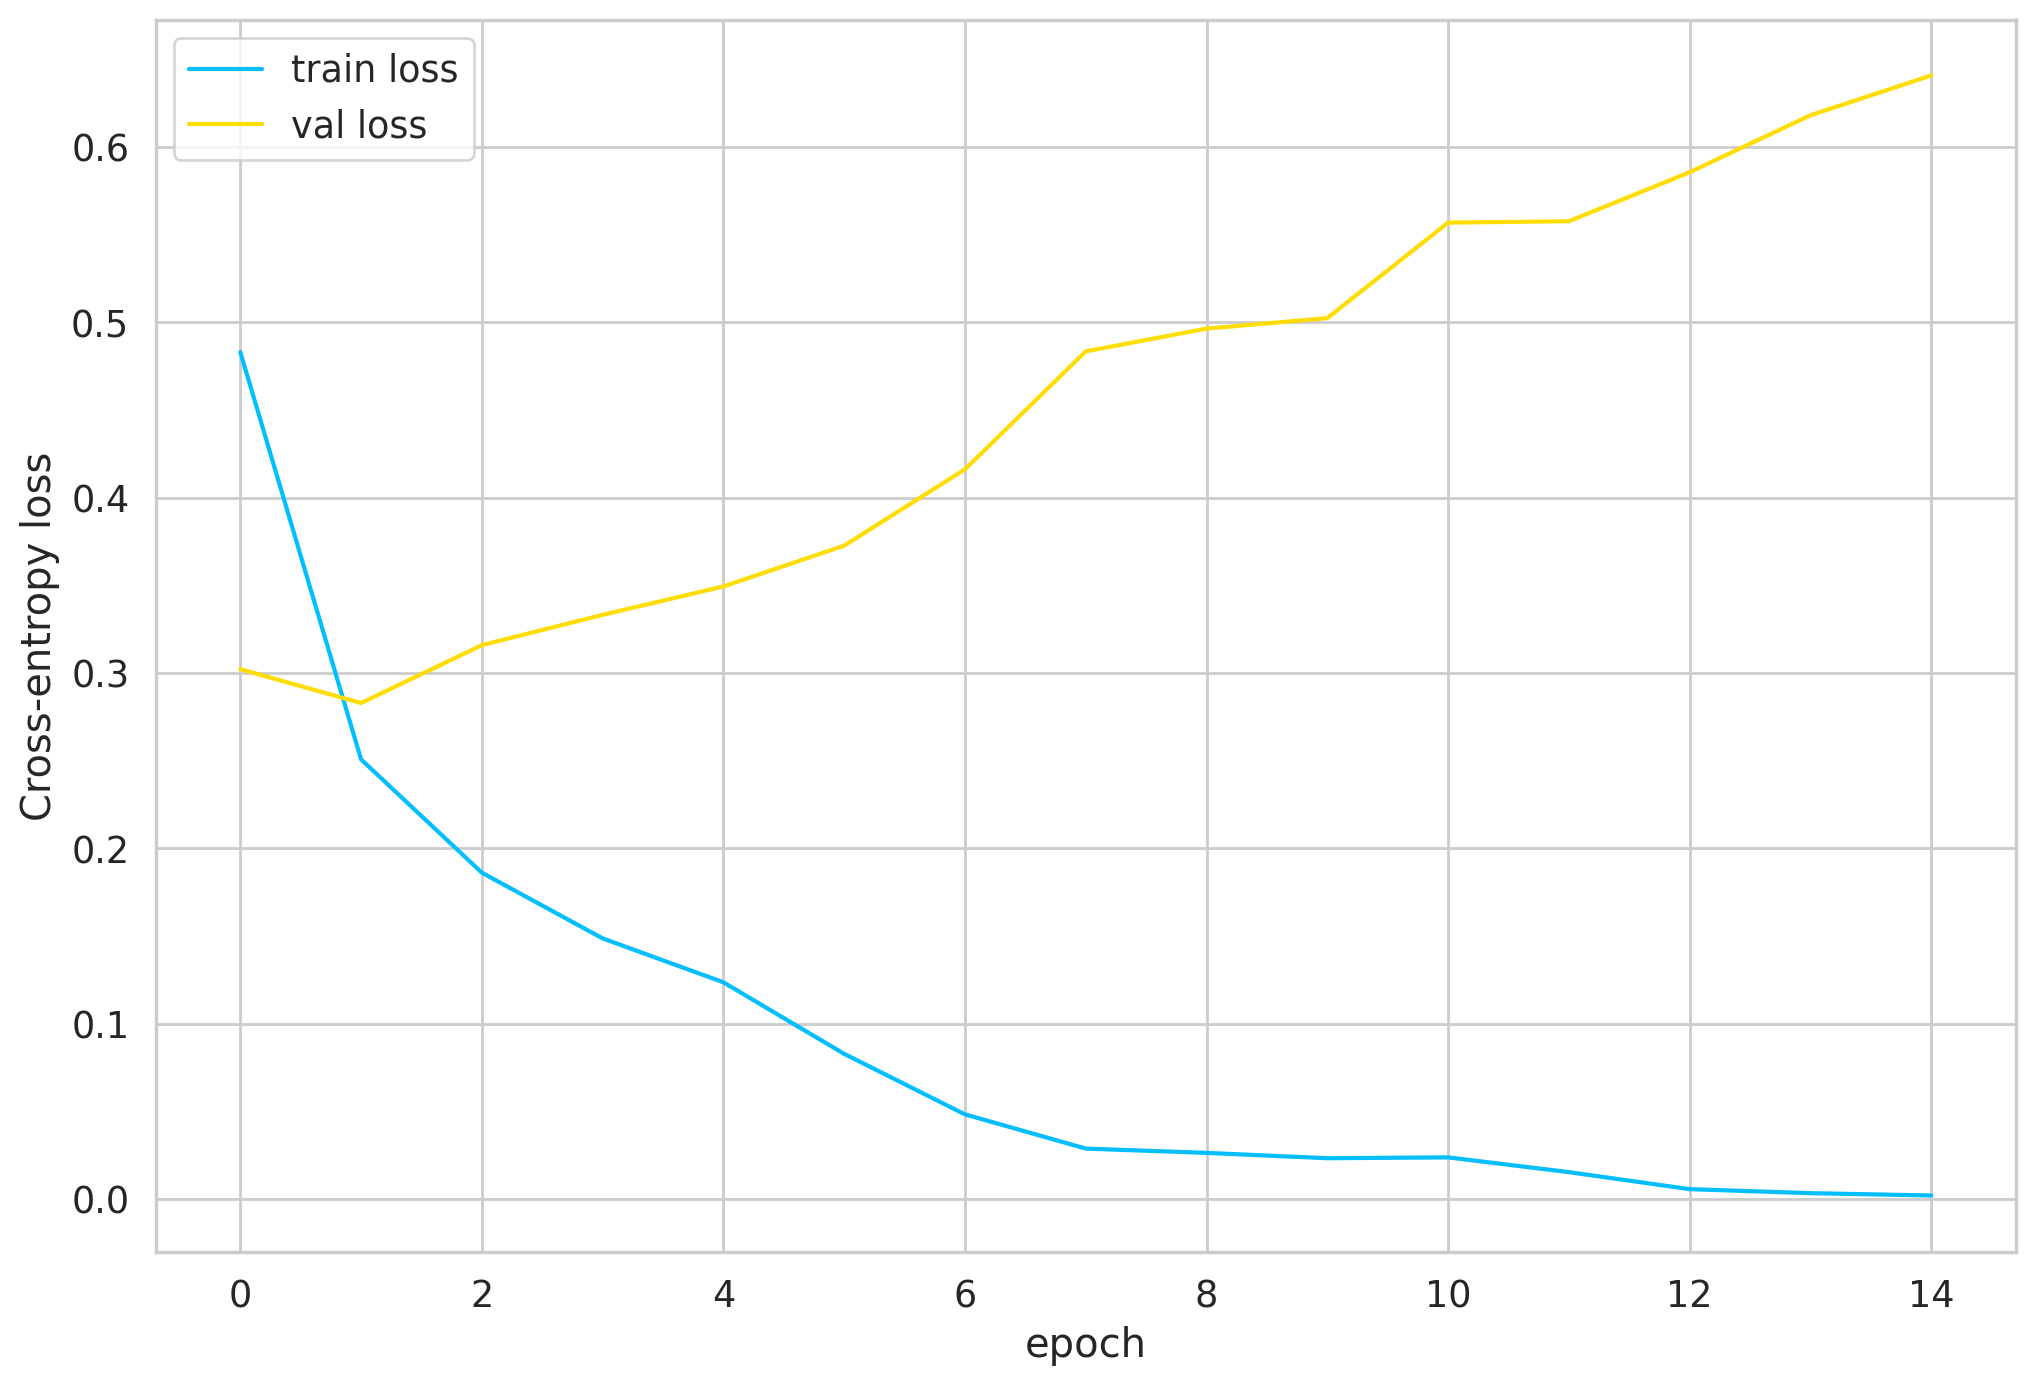

In [34]:
#show the loss value of training and validation set
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

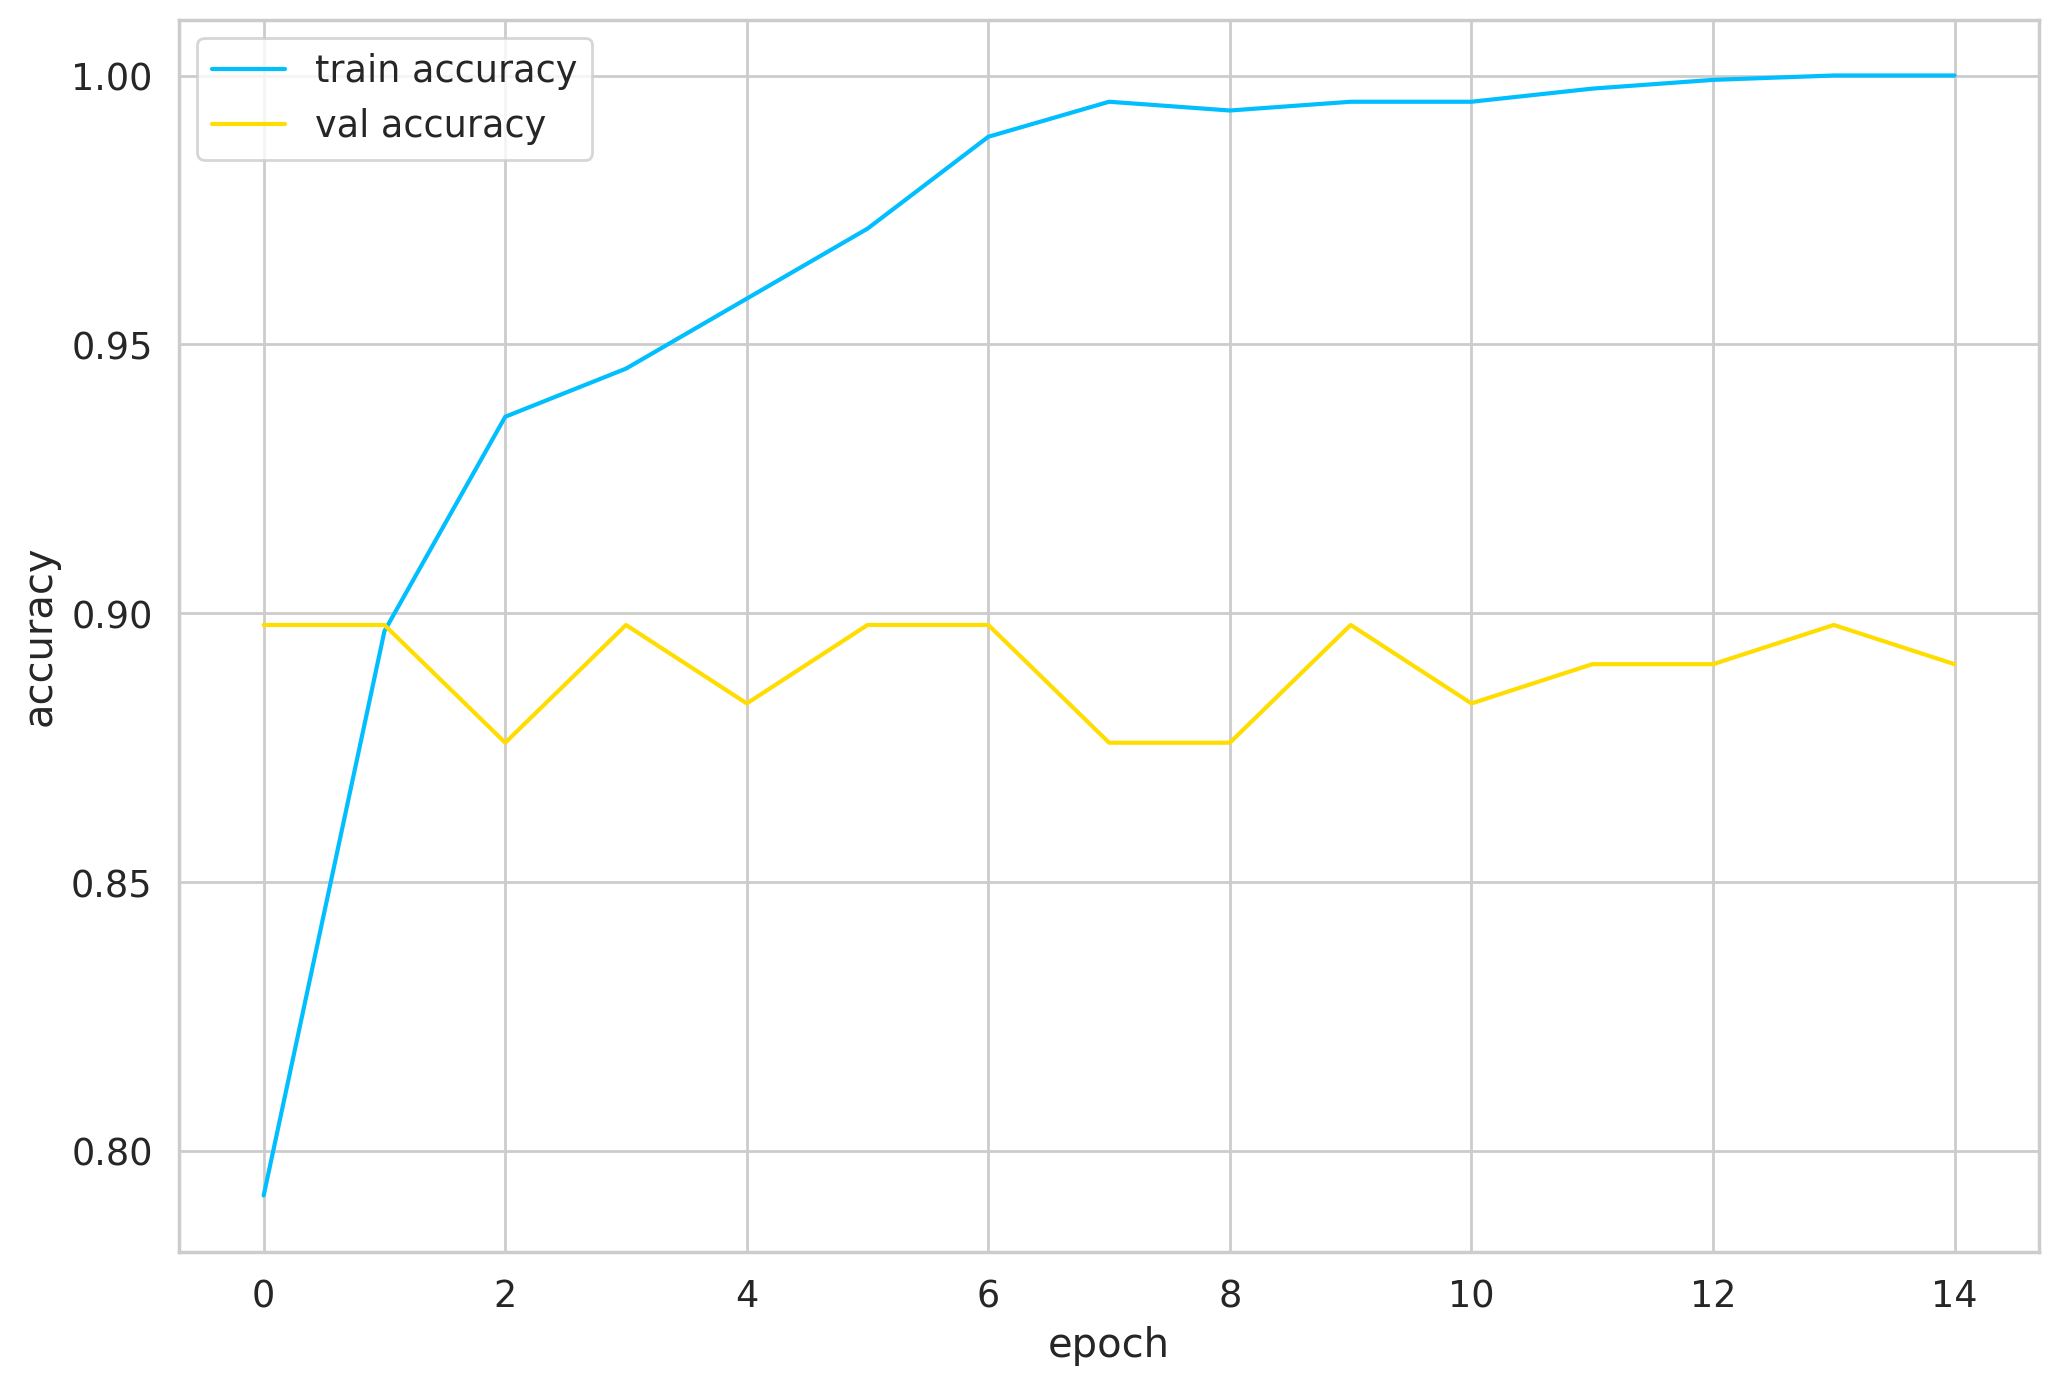

In [35]:
#show the accuracy value of training and validation set
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [36]:
print(model.evaluate(X_test, y_test)[1])

5/5 [==============================] - 0s 4ms/step - loss: 0.6044 - accuracy: 0.8947
0.8947368264198303


In [37]:
#use differnet way to approach sentiment analysis:

In [38]:
#import nltk package and some tools we want to use
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet, stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [39]:
#import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

In [40]:
# remian only score and review column
df2 = df.drop('review_type', axis=1)
df2.head()

Score                                             review
0      5  Good Quality Dog FoodI have bought several of ...
1      1  Not as AdvertisedProduct arrived labeled as Ju...
2      4  "Delight" says it allThis is a confection that...
3      2  Cough MedicineIf you are looking for the secre...
4      5  Great taffyGreat taffy at a great price.  Ther...

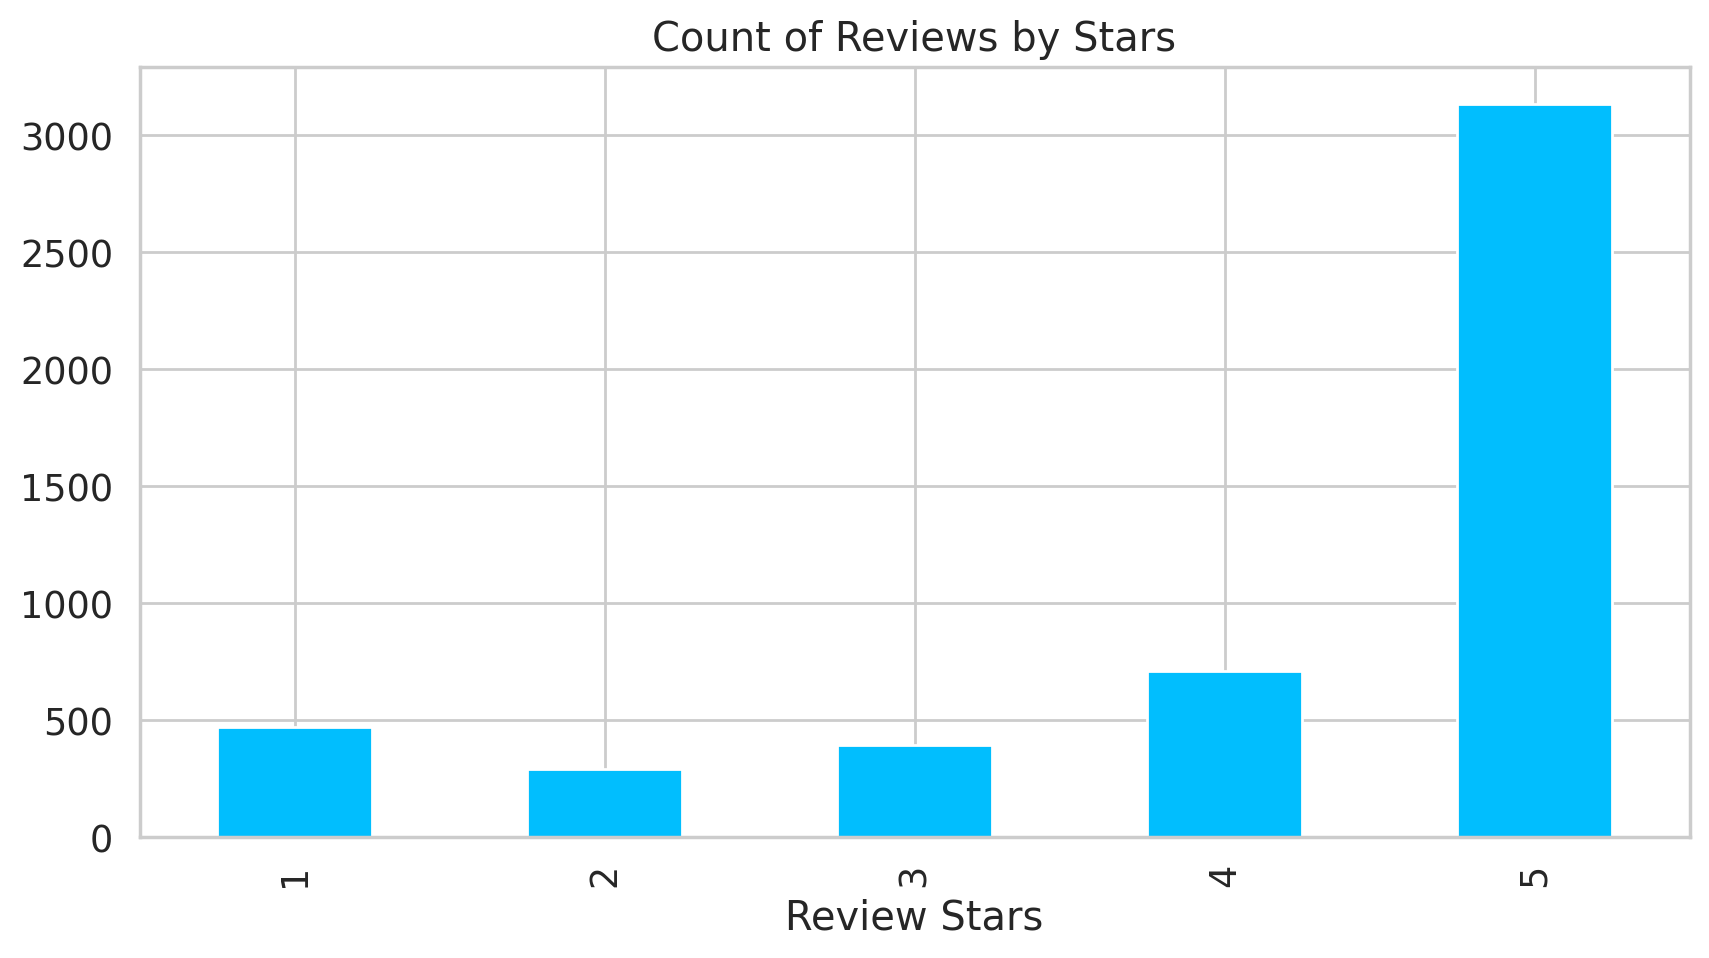

In [41]:
#show the distribution of reviews by stars
ax = df2['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [42]:
# drop any rows w/ missing values
df2 = df2.dropna()
# discover the actual counts
df2.Score.value_counts()

5    3134
4     712
1     469
3     395
2     290
Name: Score, dtype: int64

In [43]:
# set sample size to labels w/ minimum count
sample_size = 50
df_equal_overall = pd.DataFrame()
for i in df2.Score.unique():
  X = df2[df2.Score == i].sample(sample_size)
  df_equal_overall = df_equal_overall.append(X)

In [44]:
#Fundamental preprocessing
stopwords_list = stopwords.words('english')

def ReviewProcessing(df2):
  # remove non alphanumeric 
  df2['review_cleaned'] = df2.review.str.replace('[^a-zA-Z0-9 ]', '')
  # lowercase
  df2.review_cleaned = df2.review_cleaned.str.lower()
  # split into list
  df2.review_cleaned = df2.review_cleaned.str.split(' ')
  # remove stopwords
  df2.review_cleaned = df2.review_cleaned.apply(lambda x: [item for item in x if item not in stopwords_list])
  return df2

In [45]:
#build Lemmatization function
def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

  return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = nltk.stem.WordNetLemmatizer()
def get_lemmatize(sent):
  return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sent)])

In [46]:
clean_data = ReviewProcessing(df_equal_overall)
clean_data.review_cleaned = clean_data.review_cleaned.apply(' '.join)
clean_data['review_cleaned_lemmatized'] = clean_data.review_cleaned.apply(get_lemmatize)

In [47]:
clean_data.head()

Score                                             review  \
2832      5  The answer to all your Cramping problems.Origi...   
817       5  ROYAL CANIN COCKERBEST DOG FOOD ON THE MARKET ...   
685       5  Tasty!A nice case of chips that are quite tast...   
1977      5  Great starting pack!I bought this as my first ...   
1675      5  YumThat's all I can say. Yum at a great price!...   

                                         review_cleaned  \
2832  answer cramping problemsoriginally turned prod...   
817   royal canin cockerbest dog food market today  ...   
685   tastya nice case chips quite tasty definitely ...   
1977  great starting packi bought first pack kcups d...   
1675  yumthats say yum great price cant find sizes a...   

                              review_cleaned_lemmatized  
2832  answer cramp problemsoriginally turn product t...  
817   royal canin cockerbest dog food market today n...  
685   tastya nice case chip quite tasty definitely e...  
1977  great start packi bought first pack kcups defi...  
1675  yumthats say yum great price cant find size an...

In [48]:
# Word Vectorization

In [49]:
# Bag of Words, TF-IDF and 1. Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

nb = Pipeline([('vectorize', CountVectorizer(ngram_range=(1, 2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [50]:
# 2.Linear Support Vector Machine
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier()),
               ])

In [51]:
# 3.Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=500)),
               ])

In [52]:
# split train and test set
x = clean_data['review_cleaned_lemmatized']
y = clean_data['Score']
X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, stratify=y, random_state = 44)


In [53]:
# Evaluation Metrics

In [54]:
# Naive Bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes:")
print(accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# SGD Classifier
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)
print("SGD Classifier:")
print(accuracy_score(y_test, y_pred_sgd))
print(confusion_matrix(y_test, y_pred_sgd))
print(classification_report(y_test, y_pred_sgd))

# Logistic Regression
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
print("Logistic Regression:")
print(accuracy_score(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Naive Bayes:
0.34
[[6 0 2 2 0]
 [2 1 4 2 1]
 [2 1 2 4 1]
 [2 2 1 4 1]
 [0 1 1 4 4]]
              precision    recall  f1-score   support

           1       0.50      0.60      0.55        10
           2       0.20      0.10      0.13        10
           3       0.20      0.20      0.20        10
           4       0.25      0.40      0.31        10
           5       0.57      0.40      0.47        10

    accuracy                           0.34        50
   macro avg       0.34      0.34      0.33        50
weighted avg       0.34      0.34      0.33        50

SGD Classifier:
0.34
[[4 2 4 0 0]
 [1 1 4 1 3]
 [2 0 2 5 1]
 [3 1 1 4 1]
 [0 0 0 4 6]]
              precision    recall  f1-score   support

           1       0.40      0.40      0.40        10
           2       0.25      0.10      0.14        10
           3       0.18      0.20      0.19        10
           4       0.29      0.40      0.33        10
           5       0.55      0.60      0.57        10

    accuracy  

In [55]:
#use gridsearch then generating the model again to improve the model performance
from sklearn.model_selection import GridSearchCV

grid=[{'clf__solver': ['lbfgs', 'sag', 'saga'],
       'clf__C': [0.01, 0.1, 1]}]
lr = GridSearchCV(logreg, param_grid = grid, cv = 5, scoring='accuracy', verbose = 1, n_jobs = -1)
best_model = lr.fit(X_train, y_train)

print(best_model.best_estimator_)
print(best_model.best_score_)

y_pred_grid = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred_grid))
print(classification_report(y_test, y_pred_grid))
print(accuracy_score(y_test, y_pred_grid))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=500, solver='saga'))])
0.305
[[0 1 9 0 0]
 [0 1 7 1 1]
 [0 1 3 5 1]
 [0 0 5 3 2]
 [0 1 2 2 5]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        10
           2       0.25      0.10      0.14        10
           3       0.12      0.30      0.17        10
           4       0.27      0.30      0.29        10
           5       0.56      0.50      0.53        10

    accuracy                           0.24        50
   macro avg       0.24      0.24      0.22        50
weighted avg       0.24      0.24      0.22        50

0.24


# New Section